# Shows results for 510 cropped images of wheat plots

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

import import_ipynb
import wheat_dataset
from wheat_dataset import WheatDataset

from utils_dataset import get_transform_albumentation, get_transform_imgaug_img, get_transform_torch_img
from detection_transforms import Compose, PILToTensor, ConvertImageDtype, RandomHorizontalFlip
from detection_utils import collate_fn

import torch
import torchvision
from torchvision import transforms as T
from torchvision.utils import draw_segmentation_masks
from torchvision.utils import draw_bounding_boxes
import torchvision.ops as ops

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

import numpy as np
import math
import copy
import cv2
import os
import time

importing Jupyter notebook from wheat_dataset.ipynb
Seed set!


# Main Functions

In [2]:
# prediction of model   ->    returns dictionary
def predict_image_window(model, image_window, score_threshold):
    # prediction
    image_window = Image.fromarray(image_window)
    image_window = get_transform_torch_img(image_window).cuda() / 255
    prediction = model([image_window])

    # save as tensor
    prediction[0]["boxes"] = torch.Tensor(prediction[0]["boxes"].cpu().detach().numpy())
    prediction[0]["scores"] = torch.Tensor(prediction[0]["scores"].cpu().detach().numpy())
    prediction[0]["labels"] = torch.Tensor(prediction[0]["labels"].cpu().detach().numpy())
    prediction[0]["masks"] = torch.Tensor(prediction[0]["masks"].cpu().detach().numpy())

    # remove predictions with small probability (score_threshold)
    prediction[0]["boxes"] = prediction[0]["boxes"][prediction[0]["scores"] > score_threshold]
    prediction[0]["labels"] = prediction[0]["labels"][:len(prediction[0]["boxes"])]
    prediction[0]["masks"] = prediction[0]["masks"][prediction[0]["scores"] > score_threshold]
    prediction[0]["scores"] = prediction[0]["scores"][:len(prediction[0]["boxes"])]

    return prediction[0]

In [3]:
# recalculate predicted boxes on 280x280 images onto position of original 521x1721 image    ->  returns predictions dictionary with updated boxes
def recalculate_bbs(predictions, num_columns):
    for i, pred in enumerate(predictions):
        scores = copy.deepcopy(pred["scores"])
        for j, box in enumerate(pred["boxes"]):
            x1, y1, x2, y2 = copy.deepcopy(box)
            # Calculate the row and column index of the current prediction
            row_idx = int(i % (len(predictions) // num_columns))
            col_idx = i // (len(predictions) // num_columns)
            # Calculate the new coordinates based on the row and column index
            new_x1 = x1 + col_idx * 120
            new_y1 = y1 + row_idx * 240
            new_x2 = x2 + col_idx * 120
            new_y2 = y2 + row_idx * 240
            pred["boxes"][j] = torch.stack([new_x1, new_y1, new_x2, new_y2])

    return predictions

In [4]:
# calculate center and pixel area of bounding boxes   ->  returns three lists: x, y and pixel area for bounding boxes
def get_box_center(boxes):
    x_center, y_center, pixel_areas = [], [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        # calculate values
        x_mid = x1 + ((x2-x1) / 2)
        y_mid = y1 + ((y2-y1) / 2)
        pixel_area = (x2-x1) * (y2-y1)
        # append values to lists
        x_center.append(x_mid)
        y_center.append(y_mid)
        pixel_areas.append(pixel_area)
    return x_center, y_center, pixel_areas

In [5]:
def categorize_boxes(boxes):
    # x1, y1, x2, y2
    check_overlap = [(0,235,520,285), (0,475,520,525), (0,735,520,765),
                    (0,955,520,1005), (0,1195,520,1245), (0,1435,520,1485),
                    (120,0,400,1720)]

    # check_overlap = [(0,240,520,280), (0,480,520,520), (0,720,520,760),
    #                 (0,960,520,1000), (0,1200,520,1240), (0,1440,520,1480),
    #                 (240,0,280,1720)]
    # (120,0,400,1720)
    # (240,0,280,1720)

    overlap_boxes, normal_boxes = [], []
    for box in boxes:
        x1, y1, x2, y2 = box
        is_overlap = False

        for tup in check_overlap:
            if x1 >= tup[0] and x2 <= tup[2] and y1 >= tup[1] and y2 <= tup[3]:
                overlap_boxes.append(box)
                is_overlap = True
                break

        if not is_overlap:
            normal_boxes.append(box)

    overlap_boxes = torch.stack(overlap_boxes)
    normal_boxes = torch.stack(normal_boxes)
    return overlap_boxes, normal_boxes

In [6]:
def intersection_area(box1, box2):
    # Calculate the coordinates of the intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate the width and height of the intersection rectangle
    width = max(0, x2 - x1)
    height = max(0, y2 - y1)
    
    # Calculate the intersection area
    area = width * height
    
    return torch.as_tensor(area)

In [7]:
def area(box):
    x1, y1, x2, y2 = box
    width = x2 - x1
    height = y2 - y1

    return width * height

In [8]:
def intersection_filter(both_border_boxes):
    
    filtered_intersection_boxes_ids_deleted = set()
    filtered_intersection_boxes_ids = [i for i in range(both_border_boxes.shape[0])]

    copies = copy.deepcopy(both_border_boxes.tolist())

    my_count = 0

    for i in range(len(filtered_intersection_boxes_ids)-1, 0, -1):
        box1 = both_border_boxes[i]
        for j, box2 in enumerate(copies):
            if i == j:
                continue
        
            area_i = area(box1)
            intersection_ij = intersection_area(box1, box2)

            res = intersection_ij / area_i

            if res.item() > 0.5:
                filtered_intersection_boxes_ids_deleted.add(i)
                del copies[i]
                my_count += 1
                break

    filtered_intersection_boxes_ids = [i for i in range(len(filtered_intersection_boxes_ids)) if i not in filtered_intersection_boxes_ids_deleted]
    filtered_intersection_boxes = both_border_boxes[filtered_intersection_boxes_ids]

    both_border_boxes = filtered_intersection_boxes

    # print("Deleted Boxes:", my_count)

    return both_border_boxes

In [9]:
# removes overlapping boxes across all boxes and associates sub-image to box    ->     returns dict with boxes, scores and boxes with sub-image association
def remove_overlapping_boxes(predictions, iou_threshold):

    boxes = [torch.clone(prediction['boxes']) for prediction in predictions]
    scores = [torch.clone(prediction['scores']) for prediction in predictions]

    # Concat all values
    boxes = torch.cat(boxes)
    scores = torch.cat(scores)

    # Apply NMS to the boxes
    keep = ops.nms(boxes, scores, iou_threshold)

    # Filter out boxes and scores that didn't meet the score threshold
    boxes = boxes[keep]
    scores = scores[keep]

    overlap_boxes, normal_boxes = categorize_boxes(boxes)

    # print("Overlap Area Boxes:", len(overlap_boxes))
    filtered_boxes = intersection_filter(overlap_boxes)

    updated_boxes, all_intersection_unfiltered_boxes = [], []
    for box in normal_boxes:
        updated_boxes.append(box)
        all_intersection_unfiltered_boxes.append(box)
    for box in filtered_boxes:
        updated_boxes.append(box)
    for box in overlap_boxes:
        all_intersection_unfiltered_boxes.append(box)
    updated_boxes = torch.stack(updated_boxes)
    all_intersection_unfiltered_boxes = torch.stack(all_intersection_unfiltered_boxes)

    # Return the filtered boxes, scores, and masks as a dictionary
    predictions = {
        'scores': scores,
        'boxes': boxes,
        'normal_boxes': normal_boxes,
        'overlap_boxes': overlap_boxes,
        'all_inter_unf_boxes': all_intersection_unfiltered_boxes,
        'filtered_boxes': filtered_boxes,
        'updated_boxes': updated_boxes
    }

    return predictions

In [10]:
# get count and paths for all 510 images
def get_files(root_path):
    dir_path = r'/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/'
    all_paths = []
    count = 0
    # Iterate directory
    for path in os.listdir(dir_path):
        all_paths.append(root_path + path)
        if os.path.isfile(os.path.join(dir_path, path)):
            count += 1
    print('File count:', count)
    return(all_paths)

# Main Function and Plots

File count: 510


Selected number of images: 510
(1721, 521)


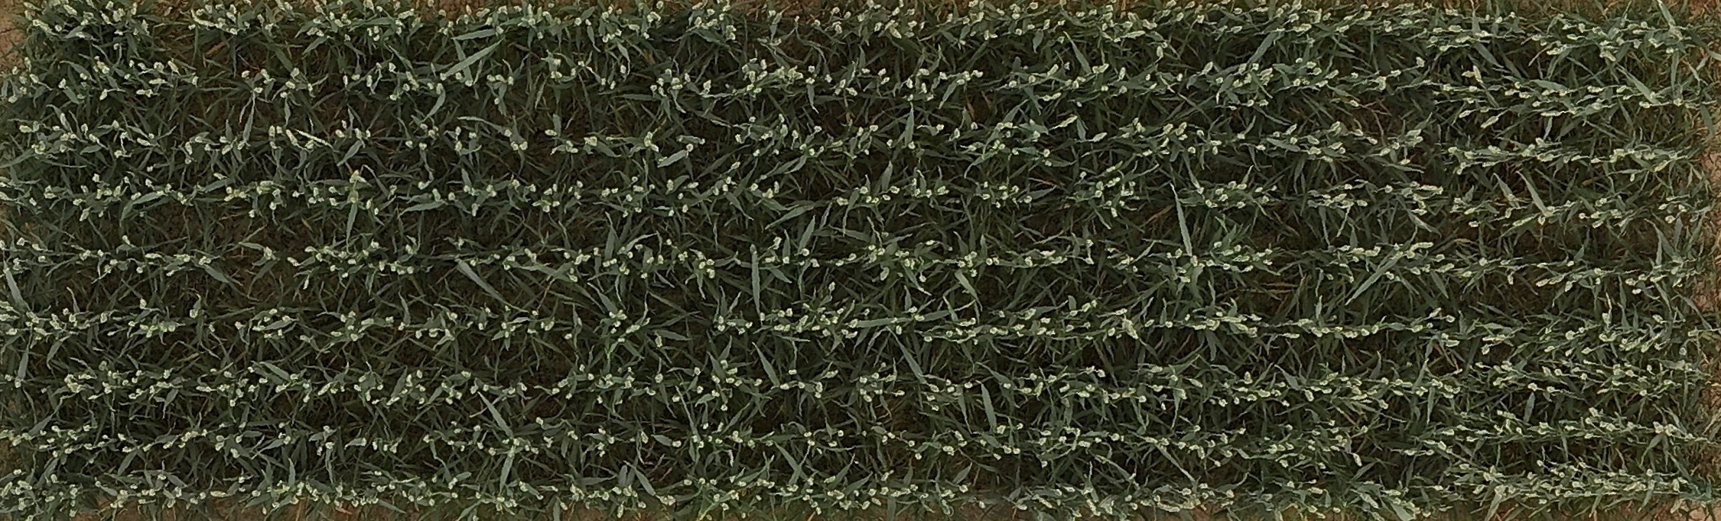

In [11]:
model_path = "/home/emj6571/model/model_5_epochs_2022-12-14_v2.pt"
model = torch.load(model_path)

root_path = "/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/"

all_paths = get_files(root_path)
images_list = []

indices = torch.randperm(len(all_paths)).tolist()
number_of_images = len(all_paths)

# for path in all_paths:
#     if path == '/data/departments/schoen/roessle/HSWT_Aehrenzaehlen/images_full_plots/DOP_AD22_HZ_D10_RGB_18mm_UTM32_____multi_band___parcel_10108_buff_0.0.tif':
#         image = path

# preprocess images
for index in indices[:number_of_images]:
    image = all_paths[index]
    im = Image.open(image)
    im = im.rotate(85, expand=True)

    # (left,top), (right,bottom)
    im = im.crop((350, 325, 2600, 1025))
    # im = im.crop((350, 400, 2600, 950))
    im = im.resize(size=(1721, 521))
    # part_im_left= im.crop((200, 40, 400, 240))
    # part_im_right = im.crop((1320, 280, 1520, 480))

    image = np.array(im)
    image = image.transpose(1,0,2)
    images_list.append(image)
        
print(f"Selected number of images: {len(images_list)}")
print(im.size)
im

In [12]:
# prediction_left = predict_image_window(model, np.array(part_im_left), 0.7)
# prediction_right = predict_image_window(model, np.array(part_im_right), 0.7)

In [13]:
# # Plot image prediction for index idx
# def window_image_plot(image, prediction):

#     # image = image.transpose(1,0)
#     boxes = prediction["boxes"]
#     n_wheatheads = len(boxes)

#     transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
#     torch_img = transform(image)
#     print(torch_img.shape)

#     torch_img_boxes = draw_bounding_boxes(torch_img, boxes, colors=(255,0,0))
#     # torch_img_masks = draw_segmentation_masks(torch_img_boxes, filtered_mask, colors=(0,0,255), alpha=0.5).permute(2,1,0)

#     # Plots normal image with boxes
#     f1 = plt.figure(figsize=(30,16))
#     plt.title(f"Part of image: {n_wheatheads} Spikes", fontsize=20)
#     implot1 = plt.imshow(torch_img_boxes.permute(1,2,0))
#     plt.show(block=True)

In [14]:
# window_image_plot(part_im_left, prediction_left)

In [15]:
# window_image_plot(part_im_right, prediction_right)

In [16]:
score_threshold = 0.7
iou_threshold = 0.2
mask_threshold = 0.5

In [17]:
def main(model, image_list, score_threshold, iou_threshold, mask_threshold):
    COLORS = [(255,0,0), (0,255,0), (0,0,255)]
    counter = 0
    image_counter = 0

    # sliding window 
    results = []
    for image in image_list:
        images = []
        # tmp = image
        step_size_width = 120
        step_size_heigth = 240
        num_columns = math.floor(image.shape[1] / (280-120))
        (w_width, w_height) = (280, 280)
        for x in range(0, image.shape[1] - w_width , step_size_width):       # width
            for y in range(0, image.shape[0] - w_height, step_size_heigth):    # heigth
                image_window = image[y:y + w_height, x:x + w_width, :]
                images.append(image_window)
                # cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), COLORS[counter], 2)   # show sub-image crops
            counter += 1
        sub_image_count = len(images)

        # predictions for sliding window     
        predictions = []
        parcel_count = []
        for i, image in enumerate(images, start=1):
            prediction = predict_image_window(model, image, score_threshold)
            predictions.append(prediction)
            parcel_count.append(len(prediction["boxes"][prediction["scores"] > score_threshold]))

        print(f"Image Number: {image_counter}")

        predictions = recalculate_bbs(predictions, num_columns)

        sub_image_boxes = [pred["boxes"] for pred in predictions]

        predictions = remove_overlapping_boxes(predictions, iou_threshold)

        x_filtered, y_filtered, pixel_areas = get_box_center(predictions["updated_boxes"])
        
        results.append([images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes])
        image_counter += 1
        
    return results

In [18]:
start = time.time()
results = main(model, images_list, score_threshold, iou_threshold, mask_threshold)
end = time.time()
print("")
print(f"Time elapsed: {np.round(end - start, 2)} seconds")
# took 1767.7 seconds for 510 images
# took 22521.3 seconds for 510 images (with intersection removal)

Image Number: 0


Image Number: 1
Image Number: 2
Image Number: 3
Image Number: 4
Image Number: 5
Image Number: 6
Image Number: 7
Image Number: 8
Image Number: 9
Image Number: 10
Image Number: 11
Image Number: 12
Image Number: 13
Image Number: 14
Image Number: 15
Image Number: 16
Image Number: 17
Image Number: 18
Image Number: 19
Image Number: 20
Image Number: 21
Image Number: 22
Image Number: 23
Image Number: 24
Image Number: 25
Image Number: 26
Image Number: 27
Image Number: 28
Image Number: 29
Image Number: 30
Image Number: 31
Image Number: 32
Image Number: 33
Image Number: 34
Image Number: 35
Image Number: 36
Image Number: 37
Image Number: 38
Image Number: 39
Image Number: 40
Image Number: 41
Image Number: 42
Image Number: 43
Image Number: 44
Image Number: 45
Image Number: 46
Image Number: 47
Image Number: 48
Image Number: 49
Image Number: 50
Image Number: 51
Image Number: 52
Image Number: 53
Image Number: 54
Image Number: 55
Image Number: 56
Image Number: 57
Image Number: 58
Image Number: 59
Image 

In [19]:
# # Plot image prediction for index idx
# def image_plot_overlap(results, image, idx):
#     images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes = results[idx]

#     print(image.size)

#     check_coordinates = [(35, 205, 235, 405)]

#     updated_boxes = []
#     for box in predictions["updated_boxes"]:
#         x1, y1, x2, y2 = box

#         for tup in check_coordinates:
#             if x1 >= tup[0] and x2 <= tup[2] and y1 >= tup[1] and y2 <= tup[3]:
#                 updated_boxes.append(box)
#                 break

#     # for box in predictions["overlap_boxes"]:
#     #     x1, y1, x2, y2 = box

#     #     for tup in check_coordinates:
#     #         if x1 >= tup[0] and x2 <= tup[2] and y1 >= tup[1] and y2 <= tup[3]:
#     #             updated_boxes.append(box)
#     #             break

#     updated_boxes = torch.stack(updated_boxes)


#     transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
#     torch_img = transform(image)

#     torch_img_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), updated_boxes, colors=(255,0,0))

#     n_wheatheads = len(updated_boxes)

#     crop = torchvision.transforms.functional.crop(torch_img_boxes, 200, 40, 200, 200)

#     # Plots normal image with boxes
#     f1 = plt.figure(figsize=(30,16))
#     plt.title(f"Image of big plot - Wheat count: {n_wheatheads}", fontsize=20)
#     implot1 = plt.imshow(crop.permute(2,1,0))
#     plt.show(block=True)

In [20]:
# image_plot_overlap(results, im, 0)

In [21]:
# window_image_plot(part_im_left, prediction_left)

In [22]:
# def main_image_window(model, image_list, score_threshold, iou_threshold, mask_threshold):
#     COLORS = [(255,0,0), (0,255,0), (0,0,255)]
#     counter = 0
#     image_counter = 0

#     # sliding window 
#     results = []
#     for image in image_list:
#         images = []
#         image_window = image[520:800, 120:400, :]
#         images.append(image_window)
#         counter += 1
#         sub_image_count = len(images)

#         # predictions for sliding window     
#         predictions = []
#         parcel_count = []
#         for i, image in enumerate(images, start=1):
#             prediction = predict_image_window(model, image, score_threshold)
#             predictions.append(prediction)
#             parcel_count.append(len(prediction["boxes"][prediction["scores"] > score_threshold]))

#         # print(f"Standard Deviation of all parcels: {np.round(np.std(parcel_count), 5)}")
#         print(f"Image Number: {image_counter}")

#         # predictions = recalculate_bbs(predictions, num_columns)

#         old_boxes = []
#         for pred in predictions:
#             old_boxes.append(pred["boxes"])

#         predictions = remove_overlapping_boxes(predictions, iou_threshold)
#         x_filtered, y_filtered, pixel_areas = get_box_center(predictions["boxes"])
#         n_wheatheads = len(predictions["boxes"])
        
#         results.append([images, predictions, n_wheatheads, predictions["boxes"], x_filtered, y_filtered, pixel_areas, old_boxes])
#         image_counter += 1
        
#     return results

In [23]:
# start = time.time()
# results_image_window = main_image_window(model, images_list, score_threshold, iou_threshold, mask_threshold)
# end = time.time()
# print("")
# print(f"Time elapsed: {np.round(end - start, 8)} seconds")
# # took 80.8 seconds for 510 images

# Plot of Image Predictions

In [24]:
# Plot image prediction for index idx
def image_plot(results, images_list, idx):
    images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes = results[idx]
    image = images_list[idx]
    image = image.transpose(1,0,2)

    transform = T.Compose([T.ToTensor(), T.ConvertImageDtype(torch.uint8)])
    torch_img = transform(image)

    torch_img_boxes = draw_bounding_boxes(torch_img.permute(0,2,1), predictions["normal_boxes"], colors=(255,0,0))
    torch_img_boxes_b = draw_bounding_boxes(torch_img.permute(0,2,1), predictions["filtered_boxes"], colors=(255,0,0))
    torch_img_boxes_c = draw_bounding_boxes(torch_img.permute(0,2,1), predictions["updated_boxes"], colors=(255,0,0))
    torch_img_boxes_d = draw_bounding_boxes(torch_img.permute(0,2,1), predictions["all_inter_unf_boxes"], colors=(255,0,0))
    # torch_img_masks = draw_segmentation_masks(torch_img_boxes, filtered_mask, colors=(0,0,255), alpha=0.5).permute(2,1,0)
    
    a = len(predictions["all_inter_unf_boxes"])
    b = len(predictions["normal_boxes"])
    d = len(predictions["updated_boxes"])

    # Plots normal image with boxes
    f0 = plt.figure(figsize=(30,16))
    plt.title(f"Image of non-filtered spikes - Wheat count: {a}", fontsize=20)
    implot1 = plt.imshow(torch_img_boxes_d.permute(2,1,0))

    f1 = plt.figure(figsize=(30,16))
    plt.title(f"Image of most spikes - Wheat count: {b}", fontsize=20)
    implot1 = plt.imshow(torch_img_boxes.permute(2,1,0))

    f3 = plt.figure(figsize=(30,16))
    plt.title(f"Image of updated spikes - Wheat count: {d}", fontsize=20)
    implot1 = plt.imshow(torch_img_boxes_c.permute(2,1,0))
    plt.show(block=True)

In [1]:
"""Single Plot; benötigt Masken, welche in dieser Datei wegen Speichergründen nicht abgespeichert werden"""
image_plot(results, images_list, 0)

NameError: name 'image_plot' is not defined

# Single Image Evaluation

In [26]:
# estimate single full plot using a single 280x280 plot
def estimation(results, images_list, idx, details=True, plot=True):
    images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes = results[idx]
    
    total_wheatheads = len(predictions["updated_boxes"])

    print(f"Total Wheat Heads: {total_wheatheads}\n")

    estimations = []
    row = []
    array = []
    full_plot_size = 521*1721
    small_plot_size = 280*280
    inverse_proportion = full_plot_size / small_plot_size

    for i, image in enumerate(images):

        # Count-based estimation
        count_small_plot = len(sub_image_boxes[i])
        count_estimation = math.floor(inverse_proportion * count_small_plot)

        if details:
            print(f"Sub-image {i}")
            print(f"Part Wheat Heads: {count_small_plot}")
            print(f"Count-based Estimated Wheat Heads: {count_estimation}")
            print(f"Deviation (Count): {count_estimation-total_wheatheads}")
            print(f"Deviation (Percent): {np.round(((count_estimation/total_wheatheads)-1)*100, 2)}%\n")

        estimations.append(count_estimation)
        row.append(count_estimation)

        if (i+1) % 7 == 0:
            array.append(row)
            row = []

    print(f"Min estimation: {min(estimations)} | Index: {estimations.index(min(estimations))}")
    print(f"Max estimation: {max(estimations)} | Index: {estimations.index(max(estimations))}\n")

    print(torch.as_tensor(array))

    boxes = torch.as_tensor(sub_image_boxes[idx])
    boxes_original = draw_bounding_boxes(torch.as_tensor((images_list[0]), dtype=torch.uint8).permute(2,0,1), boxes, colors=(255,0,0))

    # Show single plot if needed
    if plot:
        f = plt.figure(figsize=(30,16))
        plt.title(f"Single Plot: {len(sub_image_boxes[idx])}")
        plt.imshow(boxes_original.permute(2,1,0))
        plt.show(block=True)

In [27]:
"""Single Image result for Approximation"""
estimation(results, images_list, idx=0, details=False, plot=False)

Total Wheat Heads: 1419

Min estimation: 1212 | Index: 13
Max estimation: 1601 | Index: 2

tensor([[1475, 1509, 1601, 1441, 1521, 1360, 1521],
        [1258, 1292, 1372, 1269, 1498, 1326, 1212],
        [1349, 1383, 1246, 1292, 1315, 1383, 1326]])


# Multiple Images Evaluation

In [40]:
def scatter_plot(sub_plot_estimation, full_estimation, subplot_idx):

    if subplot_idx < 7:
        letter = "A"
        idx = subplot_idx
    elif subplot_idx < 14:
        letter = "B"
        idx = subplot_idx % 7
    else:
        letter = "C"
        idx = subplot_idx % 7

    r2_list, rmse_list = [], []
    x = np.arange(len(full_estimation))

    if len(sub_plot_estimation) != len(full_estimation):
        for sb_est in sub_plot_estimation:
            r2_list.append(r2_score(full_estimation, sb_est))
            rmse_list.append(np.sqrt(mean_squared_error(full_estimation, sb_est)))
        r2_best = max(r2_list)
        r2_worst = min(r2_list)
        r2_best_index = r2_list.index(r2_best)
        r2_worst_index = r2_list.index(r2_worst)
        rmse_best = min(rmse_list)
        rmse_best_index = rmse_list.index(rmse_best)
        rmse_worst = max(rmse_list)
        rmse_worst_index = rmse_list.index(rmse_worst)
        sub_plot_estimation_best = sub_plot_estimation[r2_best_index]
        sub_plot_estimation_worst = sub_plot_estimation[r2_worst_index]

        print(f"Min R²: {min(r2_list)} - Index: {r2_list.index(min(r2_list))}")
        print(f"Max R²: {max(r2_list)} - Index: {r2_list.index(max(r2_list))}")
        print(f"Min RMSE: {min(rmse_list)} - Index: {rmse_list.index(min(rmse_list))}")
        print(f"Max RMSE: {max(rmse_list)} - Index: {rmse_list.index(max(rmse_list))}")
        print(f"All R² Values: {np.round(r2_list, 2)}")
        print(f"All RMSE Values: {np.round(rmse_list, 2)}")

        f = plt.figure(figsize=(16,16))
        plt.title(f'Best Sub-Image 3B - RMSE: {rmse_best:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation_best, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2_best:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        f = plt.figure(figsize=(16,16))
        plt.title(f'Worst Sub-Image 7C - RMSE: {rmse_worst:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation_worst, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2_worst:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        plt.show(block=True)

    else:
        r2 = r2_score(full_estimation, sub_plot_estimation)
        rmse = np.sqrt(mean_squared_error(full_estimation, sub_plot_estimation))
        r2_index = subplot_idx
        print(f"R²: {r2:.2f}")
        print(f"RMSE: {rmse:.2f}")

        f = plt.figure(figsize=(16,16))
        plt.title(f'Sub-Image {idx+1}{letter} - RMSE: {rmse:.2f}')
        plt.scatter(full_estimation, sub_plot_estimation, color='red', label=f'Data Points: {len(sub_plot_estimation)}', s=15)
        plt.plot([min(full_estimation), max(full_estimation)], [min(full_estimation), max(full_estimation)], linestyle='--', linewidth=2, color='grey', label=f'R²: {r2:.2f}')
        plt.xlabel('Sliding Window Prediction')
        plt.ylabel('Subplot Upscaling')
        plt.grid(True)
        plt.legend()

        plt.savefig(f'/home/jacobowsky/Bachelorarbeit_Emanuel_J/sp_folder/sp_{subplot_idx+1}.png')

        # plt.show(block=True)

In [29]:
def full_estimation(results, subplot_idx, plot_by_index=False):

    average_prediction = np.zeros(shape=(3,7))
    average_total_wheatheads = 0
    full_plot_size = 521*1721
    small_plot_size = 280*280
    inverse_proportion = full_plot_size / small_plot_size
    total_wheatheads_list = []
    subplot_count_dict = {}
    deviation_matrix_step = np.zeros(shape=(21)).reshape((3,7))

    # get counts for each sub-plot and add them across all plots to get the average upscaling values
    for i, full_images in enumerate(results):
        tmp = np.zeros(shape=(21))
        images = full_images[0]
        predictions = full_images[1]
        total_wheatheads = len(predictions["updated_boxes"])
        total_wheatheads_list.append(total_wheatheads)
        
        for j, image in enumerate(images):
            boxes = full_images[5][j]
            count_small_plot = len(boxes)
            count_estimation = math.floor(inverse_proportion * count_small_plot)
            if j not in subplot_count_dict:
                subplot_count_dict[j] = [count_estimation]
            else:
                subplot_count_dict[j].append(count_estimation)
            tmp[j] += count_estimation
        tmp = tmp.reshape((3,7))
        average_prediction += tmp
        average_total_wheatheads += total_wheatheads
        deviation_matrix_step += ((tmp/total_wheatheads)-1)*100
    average_prediction = average_prediction / len(results)
    average_total_wheatheads = average_total_wheatheads / len(results)

    difference_prediction_total = average_prediction - average_total_wheatheads

    deviation_matrix = ((average_prediction/average_total_wheatheads)-1)*100

    print(f"Average Total Wheatheads (Sliding Window): \n {int(average_total_wheatheads)}\n")
    print(f"Average Prediction: \n {average_prediction}\n")
    print(f"Difference Prediction: \n {difference_prediction_total}\n")
    print(f"Average Difference Prediction: {np.round(np.sum(difference_prediction_total)/21,2)}\n")
    print(f"Deviation (Percent): \n {np.round(deviation_matrix, 2)}\n")
    print(f"Deviation Step (Percent): \n {np.round(deviation_matrix_step/510, 2)}\n")
    print(f"Average Deviation: {np.round(np.sum(deviation_matrix) / 21, 2)}%\n")

    # get items of dict as list for subplot creation
    subplot_values = []
    for key, value in subplot_count_dict.items():
        subplot_values.append(value)
    
    # plot sub-plots by index
    if plot_by_index:
        scatter_plot(subplot_values[subplot_idx], total_wheatheads_list, subplot_idx)
    else:
        scatter_plot(subplot_values, total_wheatheads_list, subplot_idx)

    return average_prediction, average_total_wheatheads

Average Total Wheatheads (Sliding Window): 
 1395

Average Prediction: 
 [[1402.08431373 1429.0627451  1430.21960784 1416.52156863 1400.99215686
  1397.12352941 1365.31960784]
 [1339.42941176 1362.87058824 1373.38431373 1357.92941176 1340.32941176
  1347.36470588 1317.28431373]
 [1376.45882353 1403.20196078 1419.57058824 1409.53137255 1394.58039216
  1399.28823529 1358.4627451 ]]

Difference Prediction: 
 [[  6.71372549  33.69215686  34.84901961  21.15098039   5.62156863
    1.75294118 -30.05098039]
 [-55.94117647 -32.5        -21.98627451 -37.44117647 -55.04117647
  -48.00588235 -78.08627451]
 [-18.91176471   7.83137255  24.2         14.16078431  -0.79019608
    3.91764706 -36.90784314]]

Average Difference Prediction: -12.47

Deviation (Percent): 
 [[ 0.48  2.41  2.5   1.52  0.4   0.13 -2.15]
 [-4.01 -2.33 -1.58 -2.68 -3.94 -3.44 -5.6 ]
 [-1.36  0.56  1.73  1.01 -0.06  0.28 -2.65]]

Deviation Step (Percent): 
 [[ 0.49  2.41  2.46  1.45  0.33  0.05 -2.61]
 [-3.9  -2.17 -1.46 -2.52 -3.

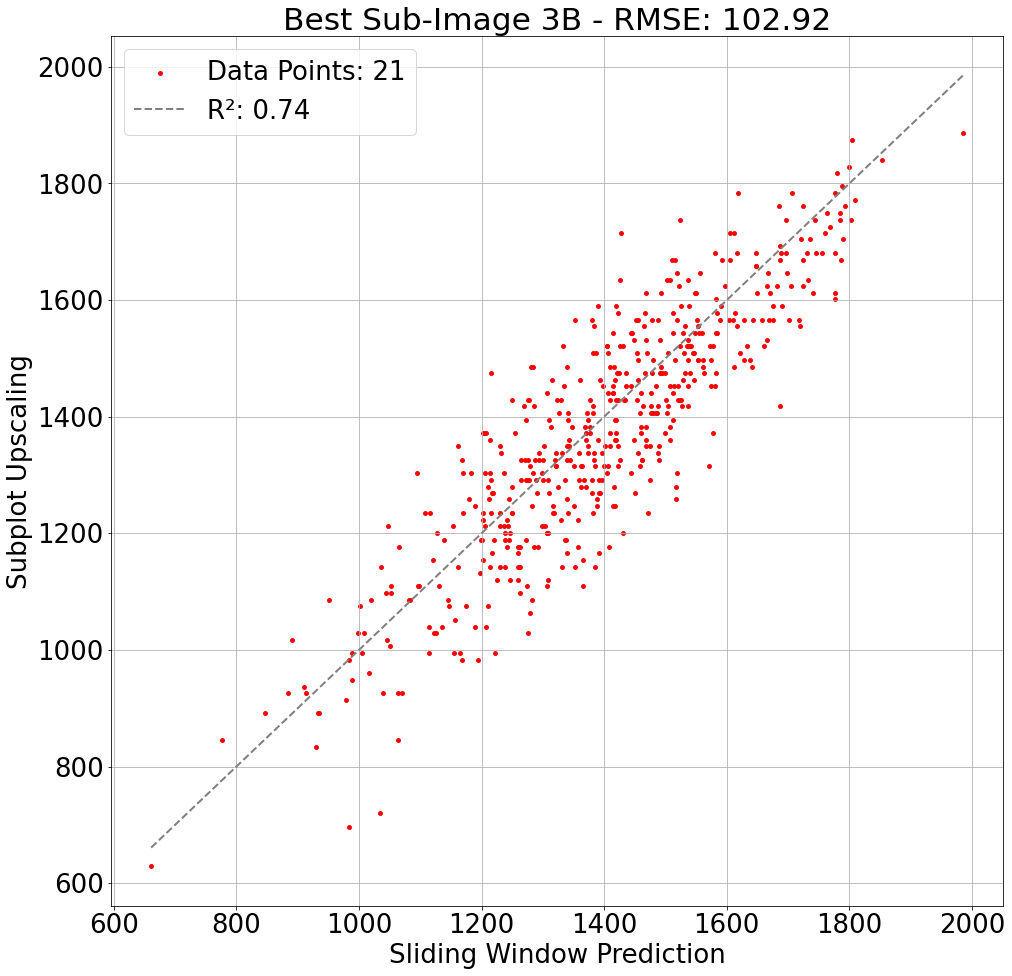

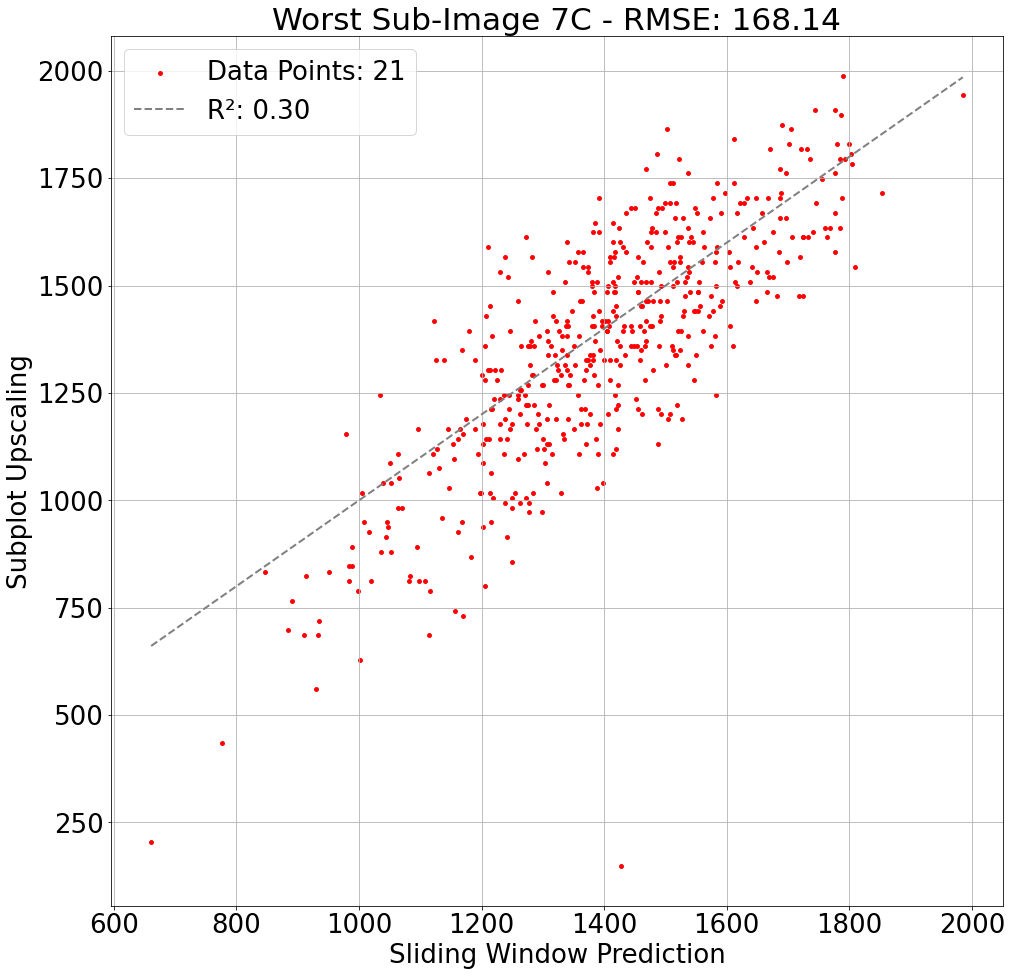

In [41]:
"""Estimation for multiple Images"""
plt.rcParams.update({'font.size': 26})
subplot_idx = 4
# for subplot_idx in range(0, 21):
average_prediction, average_total_wheatheads = full_estimation(results, subplot_idx, plot_by_index=False)

# Grid for Heatmap

In [31]:
def get_grid_counts(x_filtered, y_filtered, gridsize_heatmap, cells_w, cells_h):
    # Convert x and y coordinates to NumPy arrays
    x_filtered = np.array(x_filtered)
    y_filtered = np.array(y_filtered)
    
    # Calculate the indices of the grid cells for each point
    x_indices = np.floor(x_filtered / gridsize_heatmap).astype(int)
    y_indices = np.floor(y_filtered / gridsize_heatmap).astype(int)
    
    # Create a 2D array of zeros to store the counts for each grid cell
    grid_counts = np.zeros((cells_w, cells_h), dtype=int)

    # Increment the count for each grid cell that contains a point
    for x, y in zip(x_indices, y_indices):
        grid_counts[y][x] += 1
    
    # Transpose the array so that the rows correspond to the y axis and the columns correspond to the x axis
    counts = grid_counts.T
    
    return counts

In [32]:
# calculates grid size
gridsize_heatmap = 40
cells_w = int(1720 / gridsize_heatmap)
cells_h = int(520 / gridsize_heatmap)

In [33]:
# get grids for all images
all_grids = []
for parameters in results:
    np_grids = get_grid_counts(parameters[2], parameters[3], gridsize_heatmap, cells_w, cells_h)
    all_grids.append(np_grids)

# Plot of Heatmaps

In [34]:
# Plots count (and density) heatmap
def heatmaps(results, images_list, all_grids, gridsize_heatmap, plot, idx):
    
    images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes = results[idx]
    
    image = images_list[idx]
    np_grid = all_grids[idx]
    row, column = all_grids[0].shape

    average_counts = np.zeros(shape=(row,column))

    for grid in all_grids:
        average_counts += grid

    average_counts = np.round((average_counts / len(all_grids)), 1)

    print(f"Average counts per cell: {np.round(np.sum(average_counts) / (row*column), 1)}")

    # Plot heatmap for average of 510 images
    f = plt.figure(figsize=(30,16))
    f.add_subplot(1,1,1)
    heatmap_big = plt.imshow(average_counts, cmap='YlOrRd')
    for i in range(row):
        for j in range(column):
            plt.text(j, i, average_counts[i][j], ha="center", va="center", color="black", fontsize=15)
    plt.title("Average count heatmap for all plot images", fontsize=20)
    plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
    plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
    f.colorbar(heatmap_big, shrink=0.5)
    plt.show(block=True)
    
    # Plot heatmap and grid for single image
    if plot:
        f1 = plt.figure(figsize=(30,16))
        f1.add_subplot(1,1,1)
        heatmap_big = plt.imshow(np_grid, cmap='YlOrRd')
        for i in range(row):
            for j in range(column):
                plt.text(j, i, np_grid[i][j], ha="center", va="center", color="black", fontsize=15)
        plt.title("Count heatmap for image of plot", fontsize=20)
        plt.yticks(ticks=np.arange(row), labels=["y{}".format(i+1) for i in range(row)])
        plt.xticks(ticks=np.arange(column), labels=["x{}".format(i+1) for i in range(column)])
        f1.colorbar(heatmap_big, shrink=0.5)
        plt.show(block=True)

        f2 = plt.figure(figsize=(30,16))
        f2.add_subplot(1,1,1)
        plt.title("Grid with wheat head center points for image of plot", fontsize=20)
        plt.plot(y_filtered, x_filtered, 'ro', markersize=3)
        implot3 = plt.imshow(image.transpose(1,0,2), extent=[0, 1721, 521, 0])
        for x in range(0, 1721, gridsize_heatmap):
            plt.plot([x, x], [0, 521], c='b', linewidth=1)
        for y in range(0, 521, gridsize_heatmap):
            plt.plot([0, 1721], [y, y], c='b', linewidth=1)

        plt.show(block=True)

Average counts per cell: 2.5


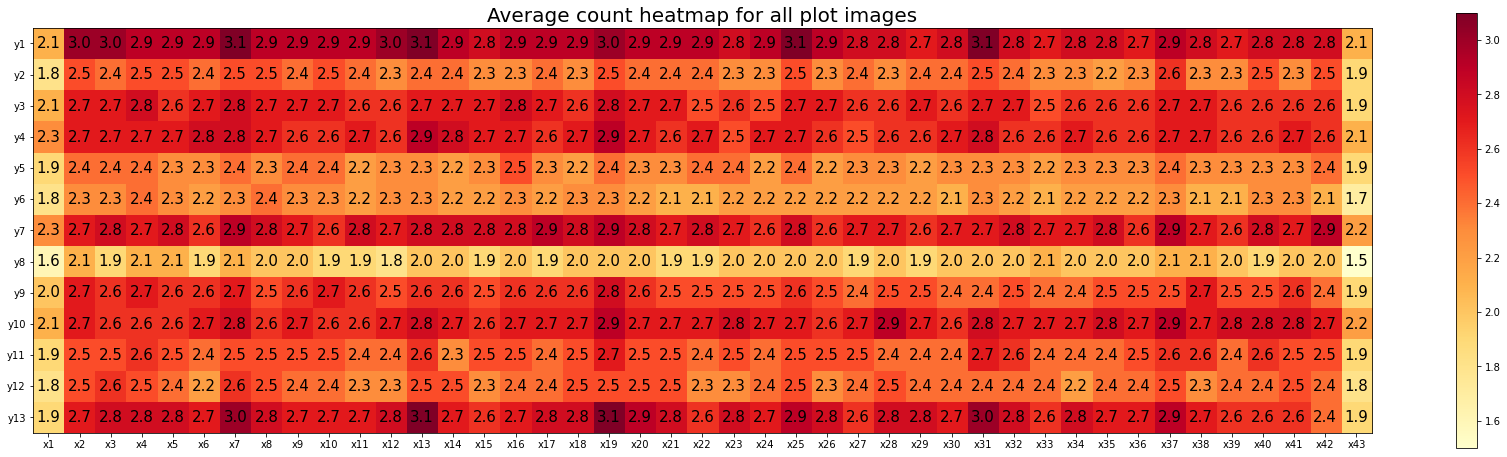

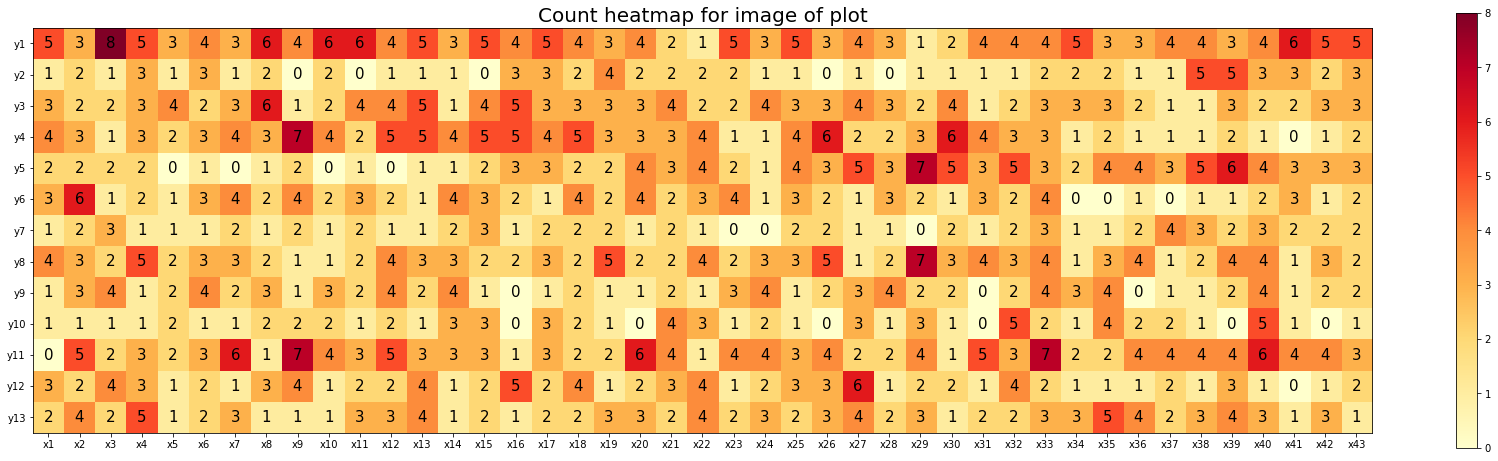

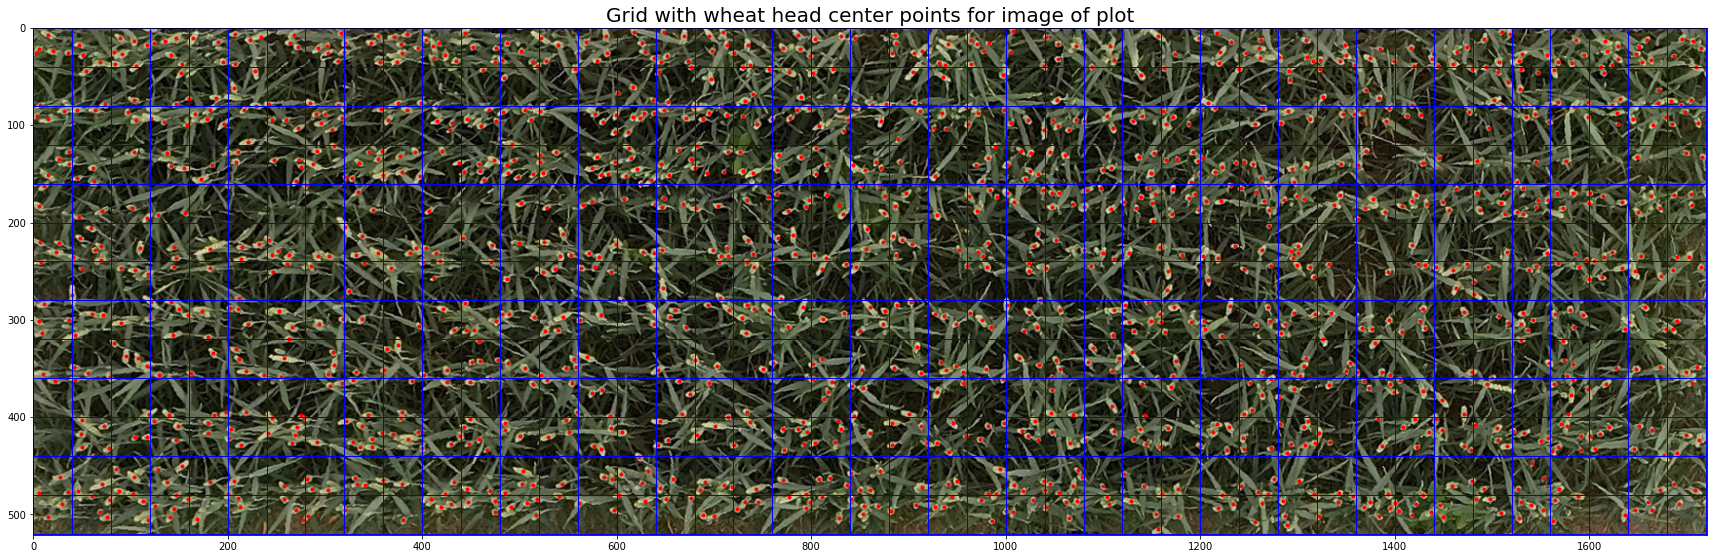

In [35]:
plt.rcParams.update({'font.size': 10})
heatmaps(results, images_list, all_grids, gridsize_heatmap, True, 0)

# Plot and stats for gradient density

In [36]:
# determines wheat heads for each area  ->  returns two lists of seperated x,y centres for each area and the areas themselfs
def density_division(modified_x, modified_y, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor):
    outer_x, middle_x, inner_x = [], [], []
    outer_y, middle_y, inner_y = [], [], []
    outer_area, middle_area, inner_area = 0,0,0

    for i, x in enumerate(modified_x):
        # outer area
        if x <= WIDTH_PIXELS or x >= (width - WIDTH_PIXELS) or modified_y[i] <= HEIGHT_PIXELS or modified_y[i] >= (height - HEIGHT_PIXELS):
            outer_x.append(x)
            outer_y.append(modified_y[i])
            outer_area += pixel_areas[i]
        # inner area
        elif (x > (n_areas+scaling_factor)*WIDTH_PIXELS and x < width - ((n_areas+scaling_factor)*WIDTH_PIXELS)) and (modified_y[i] > n_areas*HEIGHT_PIXELS and modified_y[i] < height - (n_areas*HEIGHT_PIXELS)):
            inner_x.append(x)
            inner_y.append(modified_y[i])
            inner_area += pixel_areas[i]
        # middle area
        else:
            middle_x.append(x)
            middle_y.append(modified_y[i])
            middle_area += pixel_areas[i]

    return [outer_x, middle_x, inner_x], [outer_y, middle_y, inner_y], [outer_area, middle_area, inner_area]

In [37]:
# plots gradient density map
def plot_gradient_density(results, images_list, plot):
    # container for end results
    total_wheatheads_full_images = 0
    total_blue, total_red, total_magenta = 0,0,0
    total_inner_countdensity, total_middle_countdensity, total_outer_countdensity = 0,0,0
    total_inner_areadensity, total_middle_areadensity, total_outer_areadensity = 0,0,0
    total_areadensity, total_countdensity = 0,0

    print()
    print(f"Division: Each sub-area is about 33% of the total area")

    # iterate for each image
    for j, image_values in enumerate(results):
        images, predictions, x_filtered, y_filtered, pixel_areas, sub_image_boxes = image_values
        image = images_list[j]
        image = image.transpose(1,0,2)
        height, width, channels = image.shape

        WIDTH_PIXELS = math.floor(width*0.06)
        HEIGHT_PIXELS = math.floor(height*0.1)
        COLORS = ['ro', 'bo', 'mo']
        n_areas = 2
        scaling_factor = 1.44

        x, y, areas = density_division(y_filtered, x_filtered, width, height, WIDTH_PIXELS, HEIGHT_PIXELS, n_areas, pixel_areas, scaling_factor)

        red_c, blue_c, magenta_c = len(x[0]), len(x[1]), len(x[2]) 
        total_wheatheads = red_c + blue_c + magenta_c

        outer = Rectangle((1, 1), width-1, height-1, fill=False, color='r', linewidth=2)
        middle = Rectangle((WIDTH_PIXELS, HEIGHT_PIXELS), width-2*WIDTH_PIXELS, height-2*HEIGHT_PIXELS, fill=False, color='b', linewidth=2)
        inner = Rectangle((WIDTH_PIXELS*(n_areas+scaling_factor), HEIGHT_PIXELS*n_areas), width-n_areas*(n_areas+scaling_factor)*WIDTH_PIXELS, height-n_areas*n_areas*HEIGHT_PIXELS, fill=False, color='m', linewidth=2)

        # Plot for every image
        if plot:
            f = plt.figure(figsize=(30,16))
            ax = f.add_subplot(1,1,1)
            plt.title(f"Density Division Image - Red: {len(x[0])}, Blue: {len(x[1])}, Magenta: {len(x[2])}", fontsize=20)
            for i in range(len(COLORS)):
                plt.plot(x[i], y[i], COLORS[i], markersize=4)
            implot2 = plt.imshow(image, extent=[0, width, height, 0])
            ax.add_patch(outer)
            ax.add_patch(middle)
            ax.add_patch(inner)
            plt.show(block=True)

        # Population Density for each region
        outer_area = height*width - middle.get_window_extent().width*middle.get_window_extent().height
        middle_area = middle.get_window_extent().width*middle.get_window_extent().height - inner.get_window_extent().width*inner.get_window_extent().height
        inner_area = inner.get_window_extent().width*inner.get_window_extent().height

        # Print for every image
        if plot:
            print(f"Magenta: {magenta_c} - {np.round(magenta_c/total_wheatheads*100, 3)}%")
            print(f"Blue: {blue_c} - {np.round(blue_c/total_wheatheads*100, 3)}%")
            print(f"Red: {red_c} - {np.round(red_c/total_wheatheads*100, 3)}%")
            print()
            print(f'Inner population density by count: {np.round(magenta_c/inner_area*100, 3)} wheat heads/pixel')
            print(f'Middle population density by count: {np.round(blue_c/middle_area*100, 3)} wheat heads/pixel')
            print(f'Outer population density by count: {np.round(red_c/outer_area*100, 3)} wheat heads/pixel')
            print()
            print(f'Inner population density by area: {np.round(float(areas[2])/inner_area*100, 3)}%')
            print(f'Middle population density by area: {np.round(float(areas[1])/middle_area*100, 3)}%')
            print(f'Outer population density by area: {np.round(float(areas[0])/outer_area*100, 3)}%')
            print()
            print(f"Total population density by count: {np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)}%")
            print(f"Total population density by area: {np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)}%")

        total_wheatheads_full_images += total_wheatheads

        total_blue += blue_c
        total_red += red_c
        total_magenta += magenta_c

        total_inner_countdensity += np.round(magenta_c/inner_area*100, 3)
        total_middle_countdensity += np.round(blue_c/middle_area*100, 3)
        total_outer_countdensity += np.round(red_c/outer_area*100, 3)

        total_inner_areadensity += np.round(float(areas[2])/inner_area*100, 3)
        total_middle_areadensity += np.round(float(areas[1])/middle_area*100, 3)
        total_outer_areadensity += np.round(float(areas[0])/outer_area*100, 3)

        total_areadensity += np.round((float(areas[2])+float(areas[1])+float(areas[0])) / (inner_area + middle_area + outer_area) * 100, 3)
        total_countdensity += np.round((magenta_c+blue_c+red_c) / (inner_area + middle_area + outer_area) * 100, 3)

    print("-------------------------------------------------------")
    print(f"Total wheat head spikes: {total_wheatheads_full_images}")
    print(f"Average wheat head spikes: {total_wheatheads_full_images / len(results)}")
    print()
    print(f"Total outer wheat head spikes: {total_red} - {np.round(total_red/total_wheatheads_full_images*100, 3)}%")
    print(f"Total middle wheat head spikes: {total_blue} - {np.round(total_blue/total_wheatheads_full_images*100, 3)}%")
    print(f"Total inner wheat head spikes: {total_magenta} - {np.round(total_magenta/total_wheatheads_full_images*100, 3)}%")
    print()
    print(f"Average outer wheat head spikes: {total_red / len(results)}")
    print(f"Average middle wheat head spikes: {total_blue / len(results)}")
    print(f"Average inner wheat head spikes: {total_magenta / len(results)}")
    print()
    print(f'Average inner population density by count: {total_inner_countdensity / len(results)} wheat heads/pixel')
    print(f'Average middle population density by count: {total_middle_countdensity / len(results)} wheat heads/pixel')
    print(f'Average outer population density by count: {total_outer_countdensity / len(results)} wheat heads/pixel')
    print()
    print(f'Average inner population density by area: {total_inner_areadensity / len(results)}%')
    print(f'Average middle population density by area: {total_middle_areadensity / len(results)}%')
    print(f'Average outer population density by area: {total_outer_areadensity / len(results)}%')
    print()
    print(f"Average population density by count: {total_countdensity / len(results)} wheat heads/pixel")
    print(f"Average population density by area: {total_areadensity / len(results)}%")


In [38]:
plot_gradient_density(results, images_list, False)


Division: Each sub-area is about 33% of the total area
-------------------------------------------------------
Total wheat head spikes: 711639
Average wheat head spikes: 1395.370588235294

Total outer wheat head spikes: 217772 - 30.601%
Total middle wheat head spikes: 251492 - 35.34%
Total inner wheat head spikes: 242375 - 34.059%

Average outer wheat head spikes: 427.00392156862745
Average middle wheat head spikes: 493.121568627451
Average inner wheat head spikes: 475.2450980392157

Average inner population density by count: 0.1499862745098041 wheat heads/pixel
Average middle population density by count: 0.15658627450980409 wheat heads/pixel
Average outer population density by count: 0.1611784313725492 wheat heads/pixel

Average inner population density by area: 18.461415686274506%
Average middle population density by area: 19.53379411764706%
Average outer population density by area: 20.344552941176467%

Average population density by count: 0.15563333333333348 wheat heads/pixel
Avera